In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [ ]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [ ]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [ ]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [ ]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

In [ ]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

#### Train model with checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    frequency='epoch',
    save_weights_only=True,
    verbose=1
)


In [ ]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(
    x=x_train,
    y=y_train,
    callbacks=[checkpoint]
)


In [ ]:
# Have a look at what the checkpoint creates
!ls -lh model_checkpoints


In [ ]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

#### Create new model, load weights

In [ ]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

In [ ]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

#### Clear directory

In [ ]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_500_path = \
    'model_checkpoints_500/checkpoint_{epoch:02d}_{batch:04d}'

checkpoint_5000 = ModelCheckpoint(
    filepath=checkpoint_500_path,
    save_weights_only=True,
    save_freq=5000,
    verbose=1
)

In [ ]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    validation_data=(x_test, y_test),
    batch_size=10,
    callbacks=[checkpoint_5000]
)

In [ ]:
# Have a look at what the checkpoint creates

!ls -lh model_checkpoints_500

#### Work with model saving criteria

In [ ]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [ ]:
# Create a new instance of untrained model

model = get_new_model()

In [ ]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = \
    'model_checkpoints_best/checkpoint' #_{epoch:02d}_{batch:04d}'

checkpoint_best = ModelCheckpoint(
    filepath=checkpoint_best_path,
    save_weights_only=True,
    save_freq="epoch",
    monitor="val_accuracy",
    save_best_only=True,
    #save_freq=5000,
    verbose=1
)


In [ ]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=50,
    validation_data=(x_test, y_test),
    batch_size=10,
    callbacks=[checkpoint_best],
    verbose=0
)


In [ ]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [ ]:
# Inspect the checkpoint directory

!ls -lh model_checkpoints_best/

In [ ]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)


#### Clear directory

In [ ]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq="epoch",
#     monitor="val_accuracy",
#     save_best_only=True,
#     #save_freq=5000,
    verbose=1
)

In [ ]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    callbacks=[checkpoint]
)


#### Inspect what the checkpoint has created

In [ ]:
# Have a look at what the checkpoint creates

!ls -lh {checkpoint_path}

In [ ]:
# Enter variables directory


!ls -lh {checkpoint_path}/variables

In [ ]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

#### Create new model from scratch

In [ ]:
# Delete model

del model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

#### Use the .h5 format to save model

In [ ]:
# Save the model in .h5 format

model.save("my_model.h5")

In [ ]:
# Inspect .h5 file

!ls -lh my_model.h5

In [ ]:
# Delete model

del model

In [ ]:
# Reload model from scratch

model = load_model("my_model.h5")
get_test_accuracy(model, x_test, y_test)

#### Clear directory

In [ ]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Build Keras ResNet50 model

model = load_model("models/Keras_ResNet50.h5")
model.summary()

#### Import and preprocess 3 sample images

In [ ]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [ ]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

In [ ]:
# Display image
lemon_img 


In [ ]:
# Display top 5 predictions

get_top_5_predictions(lemon_img)

##### Image 2: viaduct

In [ ]:
# Display image
viaduct_img


In [ ]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)


##### Image 3: water tower

In [ ]:
# Display image

water_tower_img

In [ ]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [2]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [4]:
# Build Google's Mobilenet v1 model

module = load_model('models/Tensorflow_MobileNet_v1')
model = tf.keras.models.Sequential(hub.KerasLayer(module))
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [13]:
# Import and preprocess 3 sample ImageNet images
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

lemon_img = load_img("data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("data/water_tower.jpg", target_size=(160, 160))

In [14]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [15]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

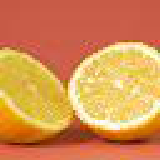

In [19]:
lemon_img

In [16]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

In [17]:
get_top_5_predictions(viaduct_img)

,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

In [18]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
